### Notebook to find differences in urban tree cover for different years

Before using this notebook, make sure you have saved the model predictions as `.npy` for the cities of interest. To run the inferences use the `inferences` notebook.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from rasterio.merge import merge
from rasterio.plot import show

In [ ]:
city_name = "Stuttgart"
year_1 = "2018"
year_2 = "2021"

year_idx = ["2018", "2021"] # needed to index the correct filepath for image_directories

# image directories that contain the original image tiles (used as a source for .tif profile)
# 1st list entry is the location of tiles for year_1, 2nd entry is the location for year_2
image_directories = {"Munich": ["path/muc_2018/tiles",
                                "path/muc_2021/tiles"],
                    "Berlin": ["path/ber_2018/tiles",
                                "path/ber_2021/tiles"],
                    "Hamburg": ["path/ham_2018/tiles",
                                "path/ham_2021/tiles"],
                    "Dortmund": ["path/dor_2018/tiles",
                                 "path/dor_2021/tiles"],
                    "Stuttgart": ["path/stu_2018/tiles",
                                  "path/stu_2021/tiles"]
                    }

# path to .npy files containing model prediction for year_1 and year_2
path_year_1 = f"path/predictions/{city_name}_{year_1}_preds.npy"
path_year_2 = f"path/predictions/{city_name}_{year_2}_preds.npy"

In [8]:
# loading arrays
preds_1 = np.load(path_year_1)
preds_2 = np.load(path_year_2)

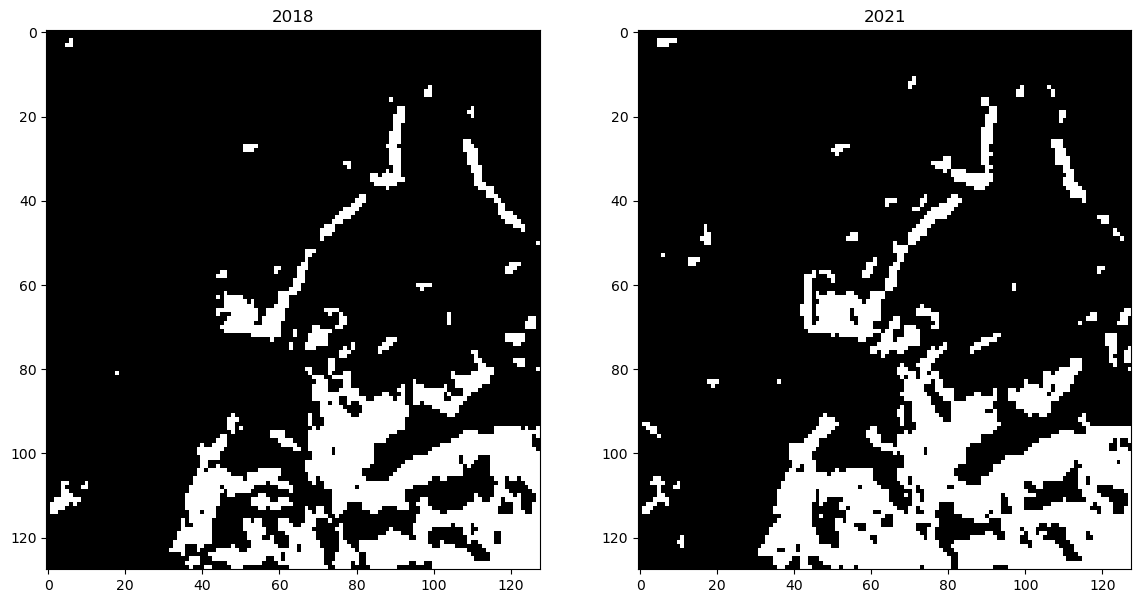

In [ ]:
# plotting the predictions
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
index = -3

new_array_ = preds_1[index]
cax1 = axs[0].imshow(new_array_[0, :, :], cmap='gray', aspect='auto')
axs[0].set_title(year_1)

new_array_ = preds_2[index]
cax2 = axs[1].imshow(new_array_[0, :, :], cmap='gray', aspect='auto')
axs[1].set_title(year_2)

plt.show()

**Calculating the difference**

In [ ]:
# calculating the change between results for two years
# difference between 2 arrays (-1.0 where pixel is not present in preds_2 but is present in preds_1, and 1.0 where pixel is not present in preds_1 but is present in preds_2) 
difference = preds_2 - preds_1

# print some array stats
# print(np.min(difference))
# print(np.max(difference))

# decrease (bool array) shows where there is a pixel in preds_1 (earlier year) which is not present in preds_2 (later year) 
decrease = difference < 0 # bool array where False pixel is "difference" array pixel of -1.0 value
# no_change (bool array) shows where there is a pixel in preds_1 (earlier year) which is also present in preds_2 (later year) 
no_change = difference == 0
# increase (bool array) shows where there is a pixel in preds_2 (earlier year) which is not present in preds_1 (later year) 
increase = difference > 0

In [ ]:
# print number of pixels
# print(decrease.sum())
# print(no_change.sum())
# print(increase.sum())

# get percentage of pixels that decrease, didn't change or increased
total_pixels = len(decrease[:]) * 128 * 128
percentage_decrease = (decrease.sum() / total_pixels) * 100
percentage_no_change = (no_change.sum() / total_pixels) * 100
percentage_increase = (increase.sum() / total_pixels) * 100

print(f"Decrease: {percentage_decrease:.2f}")
print(f"No change: {percentage_no_change:.2f}")
print(f"Increase: {percentage_increase:.2f}")

**Saving the masks as .npy files**

In [15]:
change_types = {"decrease": decrease,
                "increase": increase,
                "no_change": no_change}

In [ ]:
# saving change mask as .npy
folder_masks = f"path/change_masks/{city_name}/npy"

for key in change_types.keys():
    path_save = fr"path/change_masks/{city_name}/npy/{city_name}_{year_1}_{year_2}_{key}.npy"
    np.save(path_save, change_types[key])

**Saving the masks as .tif files**

In [ ]:
# first, saving tiles as separate files
# saving the change mask as .tif
for change_type in change_types.keys():
    path_save = f"path/change_masks/{city_name}/tiles/{change_type}"
    
    if not os.path.exists(path_save):
        os.mkdir(path_save)

    profiles = []
    # reading profiles for every original tile (defined in image_directories)
    tile_list = os.listdir(image_directories[city_name][0])
    for tile in tile_list:
        with rasterio.open(os.path.join(image_directories[city_name][0], tile)) as src:
            profiles.append(src.profile)

    counter = 0
    for tile_, profile in zip(change_types[change_type], profiles):
        counter += 1
        profile.update({"count": 1})
        # crs is used during mosaic writing to file
        crs = profile["crs"]
        path_save_tile = os.path.join(path_save, f"tile_{counter}.tif")
        with rasterio.open(path_save_tile, 'w', **profile) as dst:
            dst.write(tile_.astype(np.uint8))

In [ ]:
# saving tiles as a mosaic .tif 

for change_type in change_types.keys():

    tiles_list = os.listdir(f"path/predictions/change_masks/{city_name}/tiles/{change_type}")
    tiles_list_paths = [os.path.join(f"path/predictions/change_masks/{city_name}/tiles/{change_type}", i) for i in tiles_list]

    tiles_src = []
    for tile in tiles_list_paths:
        src = rasterio.open(tile)
        tiles_src.append(src)

    mosaic, out_trans = merge(tiles_src)

    # writing mosaic to .tif file
    path_mosaics = f"path/predictions/change_masks/{city_name}/mosaic"

    if not os.path.exists(path_mosaics):
        os.mkdir(path_mosaics)

    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans,
                     "crs": crs
                     })
    
    path_mosaic = os.path.join(path_mosaics, f"{city_name}_{year_1}_{year_2}_mosaic_{change_type}.tif")

    with rasterio.open(path_mosaic, "w", **out_meta) as dst:
        dst.write(mosaic)

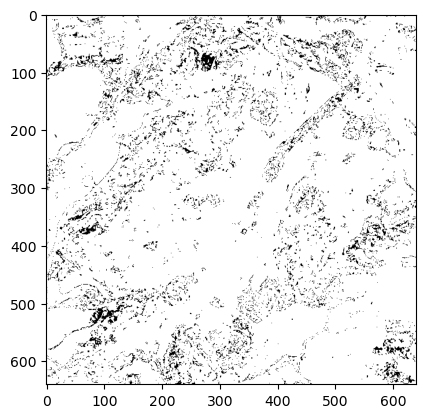

<Axes: >

In [19]:
show(mosaic, cmap='grey')